In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import interp1d
from chainconsumer import Chain, ChainConsumer

import emcee


## Corrected Luminosity distance function


In [10]:
def d_L(h, z, o_m, o_l):
    
    # Hubble distance
    #d_H = 3000/h # Mpc
    d_H = 2997.92458/h

    om_m = o_m
    om_l = o_l
    
    #om_r = 9.e-5
    # Comoving distance
    #d_C = lambda omega_m, omega_lambda: d_H/np.sqrt(omega_m * (1 + z)**3 + (1 - omega_m - omega_lambda) * (1 + z)**2 + omega_lambda ) #omega_r * (1+z)**4   omega_r=9.e-5

    ### Negative numbers inside the sqrt
    #num = om_m * (1 + z)**3 + (1 - om_m - om_l - om_r) * (1 + z)**2 + om_l + om_r * (1+z)**4
    #print(num)
    #if np.any(num < 0):
        #num = -num
    '''
    for i in num:
        if i == float('nan'):
            i = 0
            '''

    #print(num)
    #d_C = lambda: d_H/np.sqrt(num)    
    #d_C = lambda : d_H/np.sqrt(num)
    ### for flat universe
    #d_C = lambda omega_m, omega_lambda : d_H/np.sqrt(omega_m * (1 + z)**3  + omega_lambda  )
    ### for curved universe
    d_C = lambda omega_m, omega_lambda, omega_r=9.e-5 : d_H/np.sqrt(omega_m * (1 + z)**3 + (1 - omega_m - omega_lambda - omega_r) * (1 + z)**2 + omega_lambda + omega_r * (1+z)**4  )
    #d_C = lambda omega_m, omega_r=9.e-5 : 1/np.sqrt(omega_r * (1+z)**4 + omega_m * (1 + z)**3 + (1 - omega_r - omega_m )  )
    #print('d_C', d_C)


    #d_C = np.trapz(d_C(o_m, o_l), z)
    d_C = cumulative_trapezoid(d_C(o_m, o_l), z, initial=0) 
    #d_C = cumulative_trapezoid(d_C, z, initial=0) 
    #d_C = integrate.simpson(d_C(o_m, o_l), z)
    
    #print('d_C', d_C)
    #d_C = np.delete(d_C, 0)
    '''
    for i in d_C:
        if i == np.nan:
            i = 0'''
    
    #d_C = np.where(d_C==np.nan, 0, d_C)
    d_C[np.isnan(d_C)] = 0
    
    #print('d_C', d_C)
    
    omega_m = o_m
    omega_lambda = o_l
    omega_r = 9.e-5
    omega_k = 1 - omega_m - omega_lambda - omega_r


    #print('omega_k', omega_k)
    
    # Transverse comoving distance:
    if omega_k > 0:
        d_M = d_H * (1/np.sqrt(omega_k)) * np.sinh((np.sqrt(omega_k) * d_C) / d_H) 

    if omega_k == 0:
        d_M = d_C

    if omega_k < 0:
        d_M = d_H * (1/np.sqrt(-omega_k)) * np.sin((np.sqrt(-omega_k) * d_C) / d_H) 

    #print('d_M', d_M)

    d_L = (1 + z) * d_M

    #print('d_L', d_L)
    #print(d_L)
    #plt.plot(z, d_L)
    #print(d_L.shape)
    #print(d_L[0])
    if d_L[0] == 0.0:
        d_L = np.delete(d_L, 0)  #### REMOVE FIRST ELEMENT 0 FROM THE RESULT
    #print(d_L.shape)

    return d_L

In [11]:
h = 0.7
#h = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
z = np.linspace(0, 2, 10000)
z0 = np.delete(z, 0) ### for maching dimensions
#print(z)
dl = d_L(h, z, 0.6, 0.3)
dl
#z = np.delete(z, 0)
#z0.hape


array([8.56721201e-01, 1.71361367e+00, 2.57067734e+00, ...,
       1.27037312e+04, 1.27052237e+04, 1.27067163e+04])

In [12]:
func_dl= interp1d(z0, dl) ### USE Z WITHOUT ZERO TO ALLOW ACCURATE EXTRAPOLATION
func_dl(0.9)

array(5001.0979069)

## Corrected Distance Modulus

In [13]:
def distance_modulus(h, z, omega_m, omega_l):
    dl = d_L(h, z, omega_m, omega_l)
    #print('dl', dl)
    dis_mod = 5 * np.log10(dl) + 25
    #plt.plot(z, dis_mod)
    ####dis_mod = np.delete(dis_mod, 0)
    #print(z)
    #print(dis_mod.shape)
    return dis_mod

In [14]:
distance_modulus(h, z, 0.6, 0.3)

array([24.66419757, 26.16956459, 27.05023785, ..., 45.51965648,
       45.51991158, 45.52016666])

In [15]:
distance_modulus(h, z, 0.6, -0.3)

array([24.66406735, 26.16930422, 27.04984743, ..., 45.43010353,
       45.43037236, 45.43064116])

## Supernova Dataset

In [16]:
df = pd.read_csv("SCPUnion2_mu_vs_z.txt", sep="\t", header=None, names=["object_name", "redshift", "magnitude", "error_magnitude"], skiprows=5)
df

,object_name,redshift,magnitude,error_magnitude
0,1993ah,0.028488,35.335551,0.226144
1,1993ag,0.050043,36.675442,0.167114
2,1993o,0.052926,36.816881,0.155866
3,1993b,0.070086,37.440321,0.158669
4,1992bs,0.062668,37.480331,0.156270
...,...,...,...,...
552,2001gn,1.124000,44.576403,0.198691
553,2001go,0.552000,42.530251,0.105933
554,2001gq,0.671000,42.991417,0.121927
555,2001gy,0.511000,42.388163,0.089912


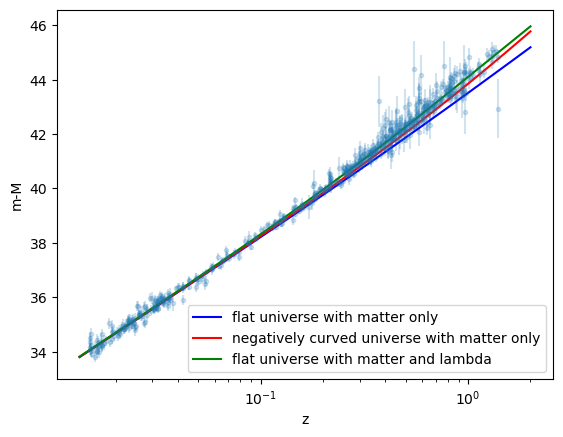

In [17]:
plt.errorbar(df['redshift'], df['magnitude'], yerr=df['error_magnitude'], fmt='.', alpha=0.2)
plt.xscale('log')
plt.xlabel("z")
plt.ylabel("m-M")


z_array = df['redshift'].to_numpy()
#print('Redshifts:', z_array)
x = np.linspace(0, 2, 150)
x0 = np.delete(x, 0)

#log_x = np.log(x)

flat_matter = distance_modulus(h, x, 0.99, 0)
neg_curve_matter = distance_modulus(h, x, 0.3, 0)
flat_matter_cosmo = distance_modulus(h, x, 0.3, 0.69)

# Interpolation

func_flat_matter = interp1d(x0, flat_matter)
func_neg_curve_matter = interp1d(x0, neg_curve_matter)
func_flat_matter_cosmo = interp1d(x0, flat_matter_cosmo)

####x = np.delete(x,0)

plt.plot(x0, flat_matter, '-b',label='flat universe with matter only')

plt.plot(x0, neg_curve_matter, '-r', label='negatively curved universe with matter only')

plt.plot(x0, flat_matter_cosmo, '-g' ,label='flat universe with matter and lambda')
plt.legend()
plt.show()
#plt.legend(loc="upper left")



## Contour Plot for $\Omega_M$ and $\Omega_\Lambda$

In [18]:
def chi_square(y_model, y, yerr):
    p = (y - y_model)**2/(yerr)**2
    return p

Text(0.5, 1.0, '$\\chi^2 - \\chi^2_{min}$')

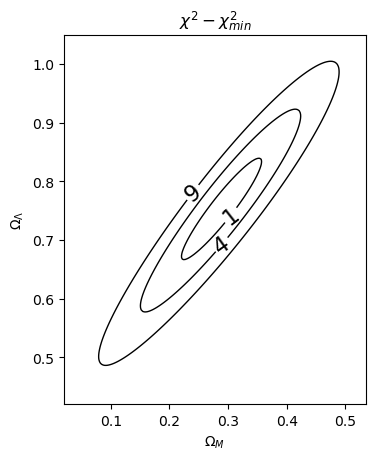

In [19]:
saveposteriors = []
save_i = []
save_j = []

nx, ny = (200, 200)
#nx, ny, nh = (50, 50, 50)


x = np.linspace(0.02, 0.535, nx) # omega_m
y = np.linspace(0.42, 1.05, ny)  # omega_lambda

#h = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
#h = np.linspace(0.5, 1, nh)

'''
x0, x1 = 0.23, 0.34
y0, y1 = 0.68, 0.83
x = np.linspace(x0, x1, nx) # omega_m
y = np.linspace(y0, y1, ny)  # omega_lambda
'''
xv, yv = np.meshgrid(x, y, indexing='xy')
#xv, yv, hv = np.meshgrid(x, y, h, indexing='xy')


saveposteriors = np.zeros((nx, ny))
#saveposteriors = np.zeros((nx, ny, nh))


z = np.linspace(0, 2, 1000)
z0 = np.delete(z, 0)
#print(z0.shape)

z_array = df['redshift'].to_numpy()
mag_array =  df['magnitude'].to_numpy()
mag_err = df['error_magnitude'].to_numpy()


for i in range(nx):
    for j in range(ny):
        #for k in range(nh):
        #print(xv[i,j, k], '  ', yv[i,j,k], '  ', zv[i,j,k])
        model1 = distance_modulus(h, z, xv[i, j], yv[i, j])
        #model1 = distance_modulus(hv[i, j, k], z, xv[i, j, k], yv[i, j, k])
        #print(xv[i,j], '  ', yv[i,j], '   ', model1.sum())#.shape)
        func_model1 = interp1d(z0, model1)
        #print(z0.shape)
        model2 = func_model1(z_array)
        post = chi_square(model2, mag_array, mag_err)
        
        l = 0
        for m in post:
            #if l == float('inf') or l == float('nan') or l == float("-inf"):
            #l = 0
            #else:
            l = l + m
            #print(k)
        #print(l)
        #if k == float('nan'):
        #print(xv[i, j],'   ', yv[i, j], '   ', k)
        saveposteriors[i][j] = l #post.sum()
        #saveposteriors[i][j][k] = l #post.sum()
        #if k == float('nan'):
        #print(xv[i, j,k],'   ', yv[i, j,k], '   ', hv[i,j,k], '   ', l)

lw = 1  # Line widths throughout the plot
fsz = 16  # Font size throughout the plot

# Square figure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')

lp = saveposteriors - saveposteriors.min()
#lp = np.exp(-(saveposteriors - saveposteriors.min()))

# Contour and labels
cs = ax.contour(x, y, lp, colors='k', linewidths=lw, levels= [1.00, 4.00, 9.00])#[2.30, 6.17, 11.8])
plt.clabel(cs, fontsize=fsz)

plt.xlabel(r'$\Omega_M$')
plt.ylabel(r"$\Omega_\Lambda$")
plt.title(r'$\chi^2 - \chi^2_{min}$')

In [20]:
print(lp.shape)
ind = np.unravel_index(np.argmin(lp, axis=None), lp.shape)
print(ind)

print('Omega_m = ', xv[ind])
print('Omega_lambda = ', yv[ind])

(200, 200)
(105, 104)
Omega_m =  0.2891457286432161
Omega_lambda =  0.7524120603015076


Text(0.5, 1.0, 'Likelihood')

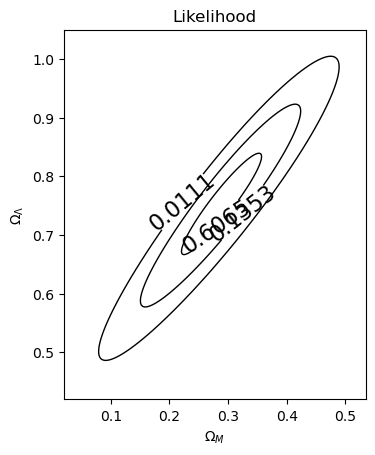

In [25]:
# Likelihood
lp1 = np.exp(-(saveposteriors - saveposteriors.min())/2)

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.set_aspect('equal')

cs1 = ax1.contour(x, y, lp1, colors='k', linewidths=lw, levels=[np.exp(-9/2),  np.exp(-4/2),  np.exp(-1/2) ])
plt.clabel(cs1, fontsize=fsz)

plt.xlabel(r'$\Omega_M$')
plt.ylabel(r"$\Omega_\Lambda$")
plt.title('Likelihood')


       $\Omega_M$  $\Omega_\Lambda$    weight
0        0.020000              0.42  0.000643
1        0.022588              0.42  0.000709
2        0.025176              0.42  0.000773
3        0.027764              0.42  0.000832
4        0.030352              0.42  0.000885
...           ...               ...       ...
39995    0.524648              1.05  0.001398
39996    0.527236              1.05  0.001296
39997    0.529824              1.05  0.001188
39998    0.532412              1.05  0.001078
39999    0.535000              1.05  0.000967

[40000 rows x 3 columns]


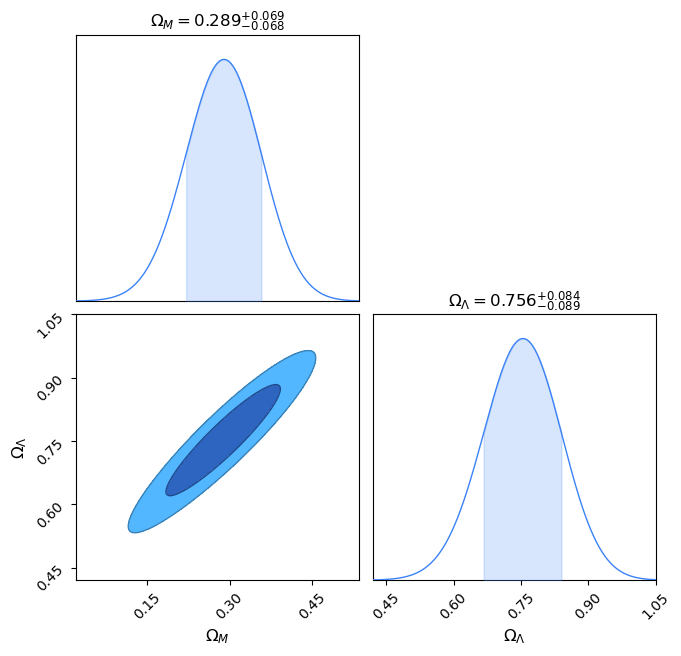

In [26]:
df1 = pd.DataFrame({"$\Omega_M$": xv.flatten(), "$\Omega_\Lambda$": yv.flatten(), "weight": lp1.flatten()})
#df1 = pd.DataFrame({"$\Omega_M$": xv.flatten(), "$\Omega_\Lambda$": yv.flatten(), "$h_0$": zv.flatten(), "weight": lp1.flatten()})
print(df1)

c = ChainConsumer()
c.add_chain(Chain(samples=df1, grid=True, name="Grid Data"))
fig = c.plotter.plot()